In [ ]:
# original at: https://www.kaggle.com/nehalbandal/tmdb-revenue-prediction-eda-ml-pipeline

## Step 3: Data Preprocessing

- In this step I will create a pipeline to handle all data preprocessing operations.
- Pipeline will do following tasks:
    - Dropping unwanted columns
    - Fill null values
    - Scaling numerical features
    (putting something into a range that makes more sense, e.g. normalize and standardize)
    - Encoding single valued & multivalued categorical fields 
    (converting something into a different representation, e.g. string to #s)
    - Creating new features from existing ones
    

In [114]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, MultiLabelBinarizer

In [115]:
# X is data without revenue column
X = data.drop(columns=['revenue'], axis=1).copy()
# Y is the all the values in the revenue column (just the revenue column)
y = data['revenue'].copy()
X.shape, y.shape

((3000, 22), (3000,))

In [116]:
from collections import Counter
top_30_values = dict()

## GENRES
# create a list of genre names (3000), skip nulls
list_of_genres_names = list(X['genres'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x)).apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
# get the 30 most occuring genres (with genres and # of occurences/frequency)
## [('Drama', 1531), ('Comedy', 1028), ('Thriller', 789), ('Action', 741), ('Romance', 571), ('Crime', 469), ('Adventure', 439), ('Horror', 301), ('Science Fiction', 290), ('Family', 260), ('Fantasy', 232), ('Mystery', 225), ('Animation', 141), ('History', 132), ('Music', 100), ('War', 100), ('Documentary', 87), ('Western', 43), ('Foreign', 31), ('TV Movie', 1)]
top_30_genres = (Counter([i for j in list_of_genres_names for i in j]).most_common(30))
# make a list of just the 30 genre names
# ['Drama', 'Comedy', 'Thriller', 'Action', 'Romance', 'Crime', 'Adventure', 'Horror', 'Science Fiction', 'Family', 'Fantasy', 'Mystery', 'Animation', 'History', 'Music', 'War', 'Documentary', 'Western', 'Foreign', 'TV Movie']
top_30_values['genres'] = [x for x, y in top_30_genres]
# print(top_30_values['genres'])

## PRODUCTION COMPANIES
list_of_production_companies_names = list(X['production_companies'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x)).apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
top_30_production_companies = (Counter([i for j in list_of_production_companies_names for i in j]).most_common(30))
top_30_values['production_companies'] = [x for x, y in top_30_production_companies]

## PRODUCTION COUNTRIES
list_of_production_countries_names = list(X['production_countries'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x)).apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
top_30_production_countries = (Counter([i for j in list_of_production_countries_names for i in j]).most_common(30))
top_30_values['production_countries'] = [x for x, y in top_30_production_countries]

## PLOT KEYWORDS
list_of_keywords = list(X['Keywords'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x)).apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
top_30_keywords = (Counter([i for j in list_of_keywords for i in j]).most_common(30))
top_30_values['Keywords'] = [x for x, y in top_30_keywords]

## CAST (ACTORS)
list_of_cast_names = list(X['cast'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x)).apply(lambda x: [i['name'] for i in x if i['order'] in (0, 1, 2)] if x != {} else []).values)
top_30_cast = (Counter([i for j in list_of_cast_names for i in j]).most_common(30))
top_30_values['cast'] = [x for x, y in top_30_cast]

In [117]:
# drop unwanted columns, assumption being that none of these relate to/inform a movie's revenue
drop_cols = ['id', 'homepage', 'imdb_id', 'original_title', 'spoken_languages', 'overview', 'poster_path', 'tagline', 'title', 'crew']

encoded_cols = [] # This will contain all the encoded column names of multivalued field

In [118]:
class CustomAttr(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        try:
            X['is_sequel'] = X['belongs_to_collection'].apply(lambda x: 0 if pd.isna(x) else 1)
#             print("is_sequel attribute added!")
            # fililng null values with 0
            # makes belongs_to_collection --> binary field is_sequel
        
        
            # taking the release_date and splitting it into multiple attributes (year, month, day, day of week)
            X['release_date']= X['release_date'].apply(lambda x: self.modify_date(x))
            
            X['release_year'] = pd.DatetimeIndex(X['release_date']).year
#             print("release_year attribute added!")
            
            X['release_month'] = pd.DatetimeIndex(X['release_date']).month
#             print("release_month attribute added!")
            
        
            X['release_day'] = pd.DatetimeIndex(X['release_date']).day
#             print("release_day attribute added!")
            
            X['release_dow'] = pd.DatetimeIndex(X['release_date']).dayofweek
#             print("release_dow attribute added!")
            
            X = X.drop(['belongs_to_collection', 'release_date'], axis=1)
#             print("belongs_to_collection, release_date attribute removed!")
            return X
        
        #print this error message when something blows up
        except Exception as e:
            print("CustomAttr: Exception caught: {}".format(e))

    @staticmethod
    def modify_date(x):
        """
            Converting date: mm/dd/YY to mm/dd/YYYY
            NaN date fields are handle here only.
        """
        try:
            if x is np.nan:
                x='01/01/00'
            x=str(x)
            year=x.split('/')[2]
            if int(year)<20:
                return x[:-2]+'20'+year
            else:
                return x[:-2]+'19'+year
        except Exception as e:
            print("CustomAttr: modify_date() function -  exception caught for date {}: {}".format(x,e))

In [119]:
class JSONHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        """
        For each multivalued field, there will be a MultiLabelBinarizer.
        """
        self.mlbs = dict()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for col in list(X.columns):
            try:
                X[col] = X[col].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x))
                X[col] = X[col].apply(lambda x: self.get_names(x, col))
                if not (col in self.mlbs.keys()):
                    self.mlbs[col] = MultiLabelBinarizer()
                    X_enc = pd.DataFrame(self.mlbs[col].fit_transform(X[col]),columns=self.mlbs[col].classes_, 
                                         index=X.index)
                    encoded_cols.extend(list(self.mlbs[col].classes_))
                else:
                    X_enc = pd.DataFrame(self.mlbs[col].transform(X[col]),columns=self.mlbs[col].classes_, 
                                         index=X.index)
                X = X.drop(col, axis=1)
                X = pd.concat([X, X_enc], axis=1)
#                 print("{}, {}, {}".format(col, X_enc.shape, X.shape))
#                 print("{} attribute encoded &  removed!".format(col))
            except Exception as e:
                print("JSONHandler: Exception caught for {}: {}".format(col,e))
        return X
       

    @staticmethod
    def get_names(x, col):
        """
            Get the name field value from JSON object.
        """
        names = []
        try:
            #replacing things without field in the top 30 with a value of 'other_'+col
            names = [item['name'] for item in x if item['name'] in top_30_values[col]]
            if len(names)==0:
                names.append('other_'+col)
            return names
        except Exception as e:
            print("JSONHandler: get_names() function -  exception caught {}: {}".format(x,e))

In [120]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                        ('scaler', PowerTransformer())])

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                         ('cat_enc', OneHotEncoder(handle_unknown='ignore'))])

# summary of prepocessing operations
pre_process = ColumnTransformer([('drop_cols', 'drop', drop_cols),
                                 ('num_process', num_pipeline, ['budget', 'popularity', 'runtime']),
                                 ('add_custom_attrs', CustomAttr(), ['belongs_to_collection', 'release_date']),
                                 ('cat_process', cat_pipeline, ['original_language', 'status']),
                                 ('jason_handler', JSONHandler(), ['genres', 'production_companies', 'production_countries', 'Keywords', 'cast'])], remainder='passthrough')

# apply the fit_transform ML thing to pre-processed data
X_transformed = pre_process.fit_transform(X)
X_transformed.shape

(3000, 191)

In [121]:
from sklearn.model_selection import train_test_split

# splitting data in test data 20% (600), training 80% (2,400)
X_train_transformed, X_test_transformed, y_train, y_test = train_test_split(X_transformed, np.log1p(y), test_size=0.2, random_state=42)
X_train_transformed.shape, X_test_transformed.shape

((2400, 191), (600, 191))

In [122]:
feature_columns = ['budget', 'popularity', 'runtime', 'is_sequel', 'release_year', 'release_month', 'release_day', 'release_dow'] + list(pre_process.transformers_[3][1]['cat_enc'].get_feature_names(['original_language', 'status'])) + encoded_cols
# top 30 values become a feature (22 to 191 columns)
# ['budget', 'popularity', 'runtime', 'is_sequel', 'release_year', 'release_month', 'release_day', 'release_dow', 'original_language_ar', 'original_language_bn', 'original_language_cn', 'original_language_cs', 'original_language_da', 'original_language_de', 'original_language_el', 'original_language_en', 'original_language_es', 'original_language_fa', 'original_language_fi', 'original_language_fr', 'original_language_he', 'original_language_hi', 'original_language_hu', 'original_language_id', 'original_language_it', 'original_language_ja', 'original_language_ko', 'original_language_ml', 'original_language_mr', 'original_language_nb', 'original_language_nl', 'original_language_no', 'original_language_pl', 'original_language_pt', 'original_language_ro', 'original_language_ru', 'original_language_sr', 'original_language_sv', 'original_language_ta', 'original_language_te', 'original_language_tr', 'original_language_ur', 'original_language_vi', 'original_language_zh', 'status_Released', 'status_Rumored', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western', 'other_genres', 'Amblin Entertainment', 'BBC Films', 'Canal+', 'Columbia Pictures', 'Columbia Pictures Corporation', 'Dimension Films', 'DreamWorks SKG', 'Dune Entertainment', 'Fox 2000 Pictures', 'Fox Searchlight Pictures', 'Hollywood Pictures', 'Lionsgate', 'Metro-Goldwyn-Mayer (MGM)', 'Miramax Films', 'New Line Cinema', 'Orion Pictures', 'Paramount Pictures', 'Regency Enterprises', 'Relativity Media', 'StudioCanal', 'Summit Entertainment', 'Touchstone Pictures', 'TriStar Pictures', 'Twentieth Century Fox Film Corporation', 'United Artists', 'Universal Pictures', 'Village Roadshow Pictures', 'Walt Disney Pictures', 'Warner Bros.', 'Working Title Films', 'other_production_companies', 'Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'China', 'Czech Republic', 'Denmark', 'France', 'Germany', 'Hong Kong', 'Hungary', 'India', 'Ireland', 'Italy', 'Japan', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Romania', 'Russia', 'South Africa', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'United Arab Emirates', 'United Kingdom', 'United States of America', 'other_production_countries', 'aftercreditsstinger', 'based on novel', 'biography', 'drug', 'duringcreditsstinger', 'dystopia', 'family', 'father son relationship', 'female nudity', 'friendship', 'high school', 'independent film', 'investigation', 'kidnapping', 'los angeles', 'love', 'murder', 'musical', 'new york', 'nudity', 'other_Keywords', 'police', 'prison', 'revenge', 'sequel', 'sex', 'sport', 'suspense', 'teenager', 'violence', 'woman director', 'Bruce Willis', 'Christian Bale', 'Colin Farrell', 'Dennis Quaid', 'Denzel Washington', 'Eddie Murphy', 'Ethan Hawke', 'Ewan McGregor', 'Gene Hackman', 'George Clooney', 'Harrison Ford', 'Jason Statham', 'John Cusack', 'Johnny Depp', 'Julia Roberts', 'Liam Neeson', 'Mark Wahlberg', 'Matt Damon', 'Mel Gibson', 'Meryl Streep', 'Michael Caine', 'Morgan Freeman', 'Nicolas Cage', 'Owen Wilson', 'Robert De Niro', 'Russell Crowe', 'Samuel L. Jackson', 'Susan Sarandon', 'Sylvester Stallone', 'Tom Hanks', 'other_cast']
len(feature_columns)
# print(feature_columns)

191

## Step 4: Modelling

In [123]:
from sklearn.model_selection import KFold
# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [124]:
from sklearn.model_selection import cross_val_score

results = []

def performance_measures(model, store_results=True):    
    train_rmses = cross_val_score(model, X_train_transformed, y_train, scoring='neg_root_mean_squared_error', cv=kf, n_jobs=-1)
    train_rmses *= -1
    train_mean_rmse = np.mean(train_rmses)
    
    test_rmses = cross_val_score(model, X_test_transformed, y_test, scoring='neg_root_mean_squared_error', cv=kf, n_jobs=-1)
    test_rmses *= -1
    test_mean_rmse = np.mean(test_rmses)
    
    print("Train Mean RMSE: {}\nTest Mean RMSE: {}".format(train_mean_rmse, test_mean_rmse))
    
    if store_results:
        results.append([model.__class__.__name__, train_mean_rmse, test_mean_rmse])

In [125]:
def plot_feature_importance(feature_columns, importance_values):
    feature_imp = [ col for col in zip(feature_columns, importance_values)]
    feature_imp.sort(key=lambda x:x[1], reverse=True)

    imp = pd.DataFrame(feature_imp[0:15], columns=['feature', 'importance'])
    plt.figure(figsize=(10, 8))
    sns.barplot(y='feature', x='importance', data=imp, orient='h')
    plt.title('15 Most Important Features', fontsize=16)
    plt.ylabel("Feature", fontsize=16)
    plt.xlabel("")
    plt.show()

In [126]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, random_state=42)
ridge_reg.fit(X_train_transformed, y_train)

Ridge(alpha=1, random_state=42)

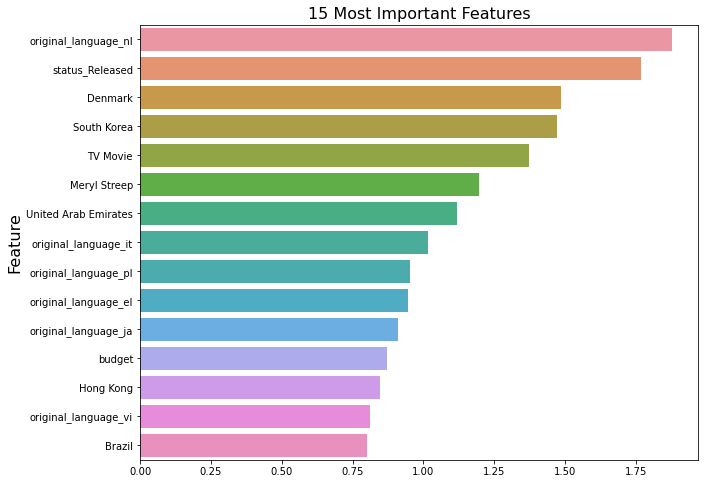

In [127]:
plot_feature_importance(feature_columns, ridge_reg.coef_)

In [128]:
performance_measures(ridge_reg) 

Train Mean RMSE: 2.2808258593945636
Test Mean RMSE: 2.264043608500647


In [129]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=500, max_depth=16, max_features=0.2, n_jobs=-1, random_state=42)
forest_reg.fit(X_train_transformed, y_train)

RandomForestRegressor(max_depth=16, max_features=0.2, n_estimators=500,
                      n_jobs=-1, random_state=42)

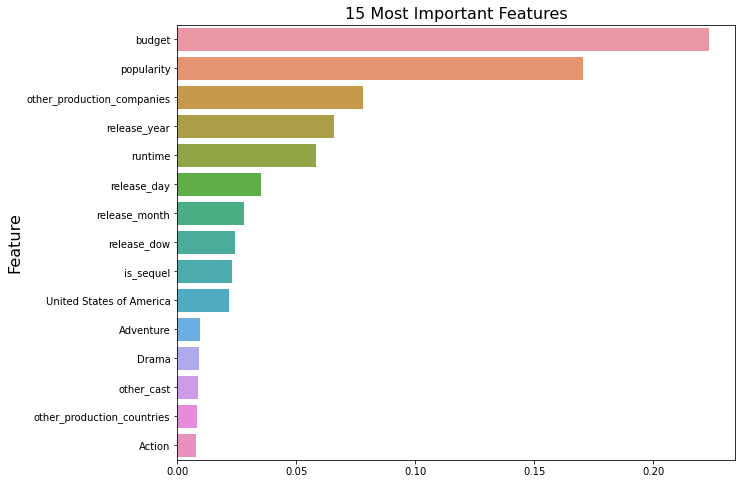

In [130]:
plot_feature_importance(feature_columns, forest_reg.feature_importances_)

In [131]:
performance_measures(forest_reg)

Train Mean RMSE: 2.148169237158104
Test Mean RMSE: 2.064892237852187


In [132]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(objective='reg:squarederror', n_estimators = 1000, max_depth = 14, learning_rate = 0.01, 
                       gamma=1.0, subsample = 0.7, colsample_bytree = 0.6, colsample_bylevel = 0.5, 
                       random_state=42, n_jobs=-1)
xgb_reg.fit(X_train_transformed, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=0.6, gamma=1.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=14,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

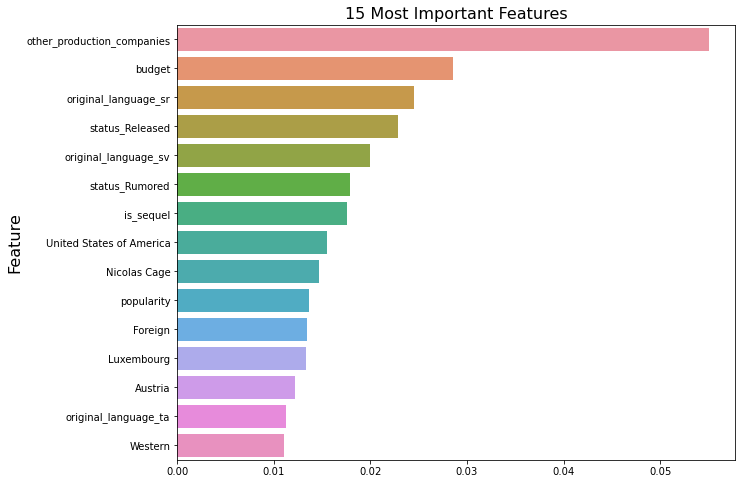

In [133]:
plot_feature_importance(feature_columns, xgb_reg.feature_importances_)

In [134]:
performance_measures(xgb_reg)

Train Mean RMSE: 2.1443107490541533
Test Mean RMSE: 2.0824226096281455


In [ ]:
from catboost import CatBoostRegressor

cat_boost_reg = CatBoostRegressor(loss_function='RMSE', bagging_temperature = 0.3, colsample_bylevel = 0.7, 
                                  depth = 9, eval_metric = 'RMSE', iterations = 1500, 
                                  random_state=42, verbose=0)
cat_boost_reg.fit(X_train_transformed, y_train)

In [ ]:
plot_feature_importance(feature_columns, cat_boost_reg.feature_importances_)

In [ ]:
performance_measures(cat_boost_reg)

In [ ]:
from lightgbm import LGBMRegressor

lgb_reg = LGBMRegressor(objective = 'regression', num_iterations = 100, max_depth = 12, learning_rate= 0.03, 
                        metric = 'rmse', colsample_bytree= 0.6, subsample_freq= 1, subsample= 0.5, n_jobs=-1, 
                        random_state=42)
lgb_reg.fit(X_train_transformed, y_train)

In [ ]:
plot_feature_importance(feature_columns, lgb_reg.feature_importances_)

In [ ]:
performance_measures(lgb_reg)

In [ ]:
from sklearn.ensemble import VotingRegressor

named_estimators = [('cat_bost', cat_boost_reg), ('xgb_reg', xgb_reg), ('lgb_reg', lgb_reg), ('forest_reg', forest_reg), ('ridge_reg', ridge_reg)]

voting_reg = VotingRegressor(estimators=named_estimators, n_jobs=-1)
voting_reg.fit(X_train_transformed, y_train)

In [ ]:
performance_measures(voting_reg)

## Step 5: Model Evaluation

In [ ]:
pd.DataFrame(results, columns=['Model', 'Train RMSE', 'Test RMSE'])

- Among all models voting regressor gives better RMLSE. I will be taking it as a final model
- Now lets see how model is performing on overall dataset. This will be helpful to understand where the model is accurate and where it is not.

In [ ]:
predicted_revenue = voting_reg.predict(X_transformed)
overall_data = X.copy()
overall_data['revenue'] = y.copy()
overall_data['predicted_revenue'] = np.expm1(predicted_revenue)

In [ ]:
overall_data.head(n=2)

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='budget', y='revenue', data=overall_data, label='Observed')
sns.scatterplot(x='budget', y='predicted_revenue', data=overall_data, color='red', label='Predicted')
plt.ylim(0, 750000000)
plt.xlim(0, 250000000)
plt.xlabel('Budget', fontsize=14)
plt.ylabel('Revenue', fontsize=14)
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_title('Revenue Vs. Budget')
plt.show()

- We can see that model is failed to predict the high revenue movies. There are many low budget high earning movies for which model has predicted less revenue.
- Also model is less accuracte for high budget films.

NOTE: model isn't doing well in 2 cases: 1) high budget movie w/ low revenue  and 2) low budget with high revenue
--> as if linear regression on budget breaks / too simple --> more factors at play

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='popularity', y='revenue', data=overall_data, label='Observed')
sns.scatterplot(x='popularity', y='predicted_revenue', data=overall_data, color='red', label='Predicted')
plt.ylim(0, 500000000)
plt.xlim(0, 50)
plt.xlabel('Popularity', fontsize=14)
plt.ylabel('Revenue', fontsize=14)
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_title('Revenue Vs. Popularity')
plt.show()

- For most popular movies, model is less accuracte.
- It seems that model has learn that for least popular movies revenue will be less. We can see that in bottom left corner, there are least popular movies which have earn high revenue, but model has predicted less.

In [ ]:
year_info = overall_data[['release_date', 'revenue', 'predicted_revenue']].copy()
year_info['release_date']=year_info['release_date'].apply(lambda x: modify_date(x))
year_info['release_year'] = pd.DatetimeIndex(year_info['release_date']).year
year_info = year_info.groupby(['release_year']).median()
year_info = year_info.sort_values('release_year')

release_years = list(year_info.index)
x_indexes = np.arange(len(release_years))     
width = 0.25                            

plt.figure(figsize=(10, 5))
plt.bar(x_indexes,  year_info['revenue'], label="Median Observed Movies Revenue", width=width)
plt.bar(x_indexes + width,  year_info['predicted_revenue'], label="Median Predicted Movies Revenue", width=width)
plt.legend(loc="upper left", fontsize=12)
plt.xticks(ticks=x_indexes+0.5, labels=release_years, fontsize=12, rotation=-45)
plt.title('1990-2017')
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.xlim(left=61.5, right=90)
plt.ylim(top=50000000)
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
plt.show()

In [ ]:
x_indexes = np.arange(len(release_years))     
width = 0.35                            

plt.figure(figsize=(10, 5))
plt.bar(x_indexes,  year_info['revenue'], label="Median Observed Movies Revenue", width=width)
plt.bar(x_indexes + width,  year_info['predicted_revenue'], label="Median Predicted Movies Revenue", width=width)
plt.legend(loc="upper left", fontsize=12)
plt.xticks(ticks=x_indexes+0.5, labels=release_years, fontsize=12, rotation=-45)
plt.title('1960-1989')
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.xlim(left=32, right=62)
plt.ylim(top=80000000)
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
plt.show()

## Step 6: Make Submission

- Now lets create final complete pipeline which will handle the data preprocessing as well as prediction task.

In [ ]:
final_model = Pipeline([('pre_process', pre_process),
                        ('voting_reg', voting_reg)])
final_model.fit(X, np.log1p(y))

In [ ]:
test_data = pd.read_csv('../input/tmdb-box-office-prediction/test.csv')
print(test_data.shape)
test_data.head(n=3)

In [ ]:
test_data.info()

In [ ]:
test_data.isna().sum()

In [ ]:
predictions = final_model.predict(test_data)
predictions = np.expm1(predictions)

In [ ]:
output = pd.DataFrame(test_data['id'])
output['revenue'] = predictions.copy()

In [ ]:
output.head()

In [ ]:
output.to_csv("./submission.csv", index=False)